# Identifying AI Software

A first attempt to build an identification mechanism to tag and classify open-source software on Github as "AI-related." The process consists of the following steps: 

1. Embedding all the open source software into a common metric space. 
2. Identifying our "ground truth" AI software. 
3. Classifying all the open source software on Github as "AI" or "not-AI". 

In [117]:
# !pip install --quiet hdmedians
# !pip install --quiet pymongo[srv,tls]
# !pip install --quiet diskcache
!pip install --quiet wordcloud

In [1]:
SS_MODEL = "ss/sentencespace"
GITHUB_EMBEDDINGS = './ss/ss_repo_embeds.txt'

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
from lib.utils import *
from repoman.filter_responses import get_repos_titles
from copy import deepcopy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]

# Embedding

We learn a vector embedding of the sentences via a library called StarSpace. The embeddings of the sentences are learned by:

1. Picking a sentence in a repository. 
2. Picking the other sentences in the repository as the "positive labels"
3. Picking a handful of random sentences from _other_ repositories as the "negative labels"

The result is an embedding model that, given a sentence of text, splits it into n-gram character tokens and embeds it into  a 100-dimensional continuous space. Sentences that are similar to other sentences in the same repository will be close to each other in the dimensional space. 

To show the power of this technique, we embed a few test words and a few test sentences and look at the heatmap of their distance in the embedded space: 

In [4]:
size = int(5472100/2)
embeddings = get_embeddings(GITHUB_EMBEDDINGS, size)

In [6]:
words = ['an accurate classification model', 'neural network', 'matlab', 'python', 'scala', 'java', 'javascript', 'html', 'bitcoin']
compare = embed_docs(SS_MODEL, '\n'.join(words))

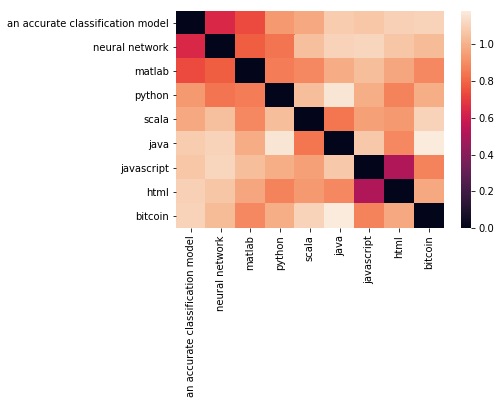

In [7]:
from scipy.spatial.distance import pdist,squareform

m = squareform(pdist(np.array(compare), 'cosine'))
_ = sns.heatmap(pd.DataFrame(m, columns = words, index= words))

Here we can see that a "neural network" and an "accurate classification model" are considered very close in the space. Similarly, "javascript" and "html" (programming languages that run together on web pages) are very close to one another. However, javascript and html are both very far from neural networks. This is exactly what we would expect, as, in the realm of programming, they have relatively little to do with one another, except when one might visualize neural networks on a webpage. 

In [ ]:
with open('./ss/eye.txt', 'r') as f:
    foo = [l.strip().split(' ') for i,l in enumerate(f)]
    eyeball_tests = [' '.join(s) for s in foo]

v = embed_doc(SS_MODEL, '\n'.join(eyeball_tests))

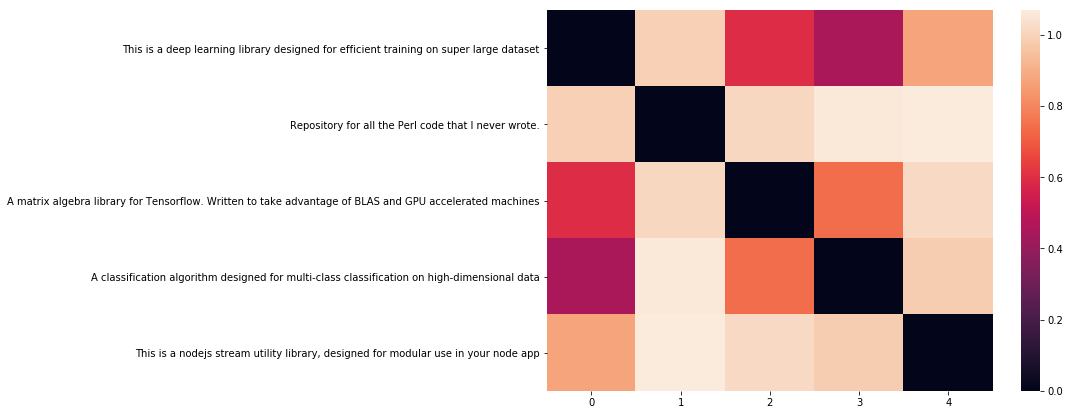

In [93]:
m = squareform(pdist(np.array(v), 'cosine'))
_ = sns.heatmap(pd.DataFrame(m, index= eyeball_tests))

This example shows that complex sentences that share no keywords can still be accurately modeled in their distance to one another. Our embedding has learned the relationship of the concepts. It should be emphasized that if we were using a simple word-count or tf-idf vector to embed documents, all of these documents would be essentially unrelated. 

Using the embedding, however, we can see that software focused on matrix algebra and GPU's (row 3) is very close to software which runs a classification algorithm on high-dimensional data (row 4), which is in turn very close to a deep-learning library (row 1). None of these is particularly close to a "nodejs stream utility" (row 5), a library that is used in building servers to handle web requests.

## Identifying AI Software

The first step in identifying AI software is to identify a technique to identify _some_ software as AI. Our process:

1. Identify the "top" 5 AI conferences, as recommended by experts. 
2. Create a list of all the paper titles from those conferences. 
3. Search for repositories that contain _exact string matches_ with these titles using Github's search API. 
4. Remove repositories that have more than 5 titles (often these are compilations of papers, not software). 
5. Remove titles that are common phrases that seem to match many repos without being references to the papers. To do this, we count the number of words in each title, and put a prior on the number number of repos associated with each title (a Gamma distribution, such that many repos are rare), and use this to regularize the number of words. Thus, a title with a couple of words and only one repository match will be kept, but a title with three or four words and many repositories matched will be thrown away. We then tune the parameters of the regularization and the decision threshold with a small set (~20) paper titles that we hand label. We ensure a precision score of 1.0, meaning that we have no false positives from our hand-labelled set.
6. This reduces the number of titles from 2380 to 1787. 
7. Collect repos that have readmes that contain a title from the reduced title list. We are then confident that each of these repositories is referencing a paper from an identified AI conference. We have 2955 repositories at this stage. 


Then, we scrape the Readme's from these repositories, and that we use as a "positive" training set, our ground truth, software that we believe to definitely be AI. 

We purposely used only 5 AI conferences, primarily because several conferences on the list contained papers and talks that were relatively far away from  what we understand to be AI. For example: The International World Wide Web conference.

We have not yet gathered statistics on the coverage we have (repositories/paper for each conference).

Given our classification technique, diminishing returns on the number of papers and repositories identified kicks in very quickly. Given the text from a handful (dozens) of exemplary AI software readmes, one can expect the classification to perform nearly as well as with thousands. Similarly, while the classifier is by design robust to random outliers, if we include many papers that we do _not_ consider core AI, it will fit the data accordingly. 

In [ ]:
repos = get_repos_titles(12)    

In [4]:
readmes = get_ai_readmes(repos, workers=15)

REPO 404: gz7seven/RGB-D
REPO 404: mck0517/SaliencyDetection


In [14]:
vecs = embed_docs(SS_MODEL, '\n'.join(readmes))

In [70]:
from scipy.spatial.distance import euclidean, cosine
from hdmedians import geomedian, medoid

def distance_from(arr, v):
    dist = lambda d: euclidean(d, v)
    return np.apply_along_axis(lambda d: euclidean(d, v), 1, arr)

def distances_from_med(vecs, embeddings, med = None):
    """ Generate distance of each embedding from medoid of vecs """
    med = med or np.asarray(medoid(vecs.T))
    return distance_from(embeddings, med)

def pick_local_sample(distances, embedding, sample_size, thresh):
    s = embeddings[distances < thresh]
    idx = np.random.choice(s.shape[0], sample_size, replace=False)
    sample = s[idx]
    return sample

In [71]:
distances = distances_from_med(vecs, embeddings)

## Classification algorithm: One-Class SVM

Support Vector Machine is a classic machine-learning algorithm that draws a boundary in the geometric space of the problem, classifying all points on one side of the boundary as positive and those on the other side as negative. 

One-class SVM seeks to draw this boundary after having only seen positive points. It can be thought of as drawing a sphere around the positive points it is trained on, and shrinking that sphere as much as possible: trading off between minimizing the volume of the sphere and maximizing the amount of points it keeps inside of it (correctly classified). 

Drawing a small random sample from the embedded space around the medoid AI repository, we can visualize the work of the classifier: 

In [72]:
from sklearn.svm import OneClassSVM

svm = OneClassSVM(kernel='rbf', nu = .4, gamma = 1/1000)

In [73]:
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, TSNE

def project(embeddings, vecs):
    mds = MDS()
    X = np.concatenate([vecs, embeddings])
    manifold = mds.fit_transform(X)
    labels = np.concatenate([np.ones(vecs.shape[0]), np.zeros(embeddings.shape[0])])
    df = pd.DataFrame(manifold, columns = ['x', 'y']).assign(source = pd.Series(labels))
    return df
    
def plot_predictions(model, df):
    df = df.copy()
    X = df[['x', 'y']].values
    vecs = X[df.source == 1]
    pos,mod = predict_ai(model, vecs, X)
    
    # Add support vectors
    df['support_vector'] = False
    df.loc[mod.support_ ,'support_vector'] = True
    
    # Add labels for source
#     lab = np.array(['Papers' if i == 1 else 'Random' for i in df.source])
    lab = df.source.map(lambda i: 'Not-AI')
    lab[pos[:,0]] = 'AI'
    df['label'] = lab
    df['source'] = df.source.map(lambda i: 'Conferences' if i == 1 else 'Random')
    sns.scatterplot(x = 'x', y = 'y', style='source', hue = 'label', data = df, markers = [',', 'P'], palette="bright")

In [74]:
sample = pick_local_sample(distances, embeddings, sample_size=1000, thresh=1.2)
sample_vecs = vecs[np.random.choice(vecs.shape[0], 500, replace=False)]

In [75]:
df = project(sample, sample_vecs)

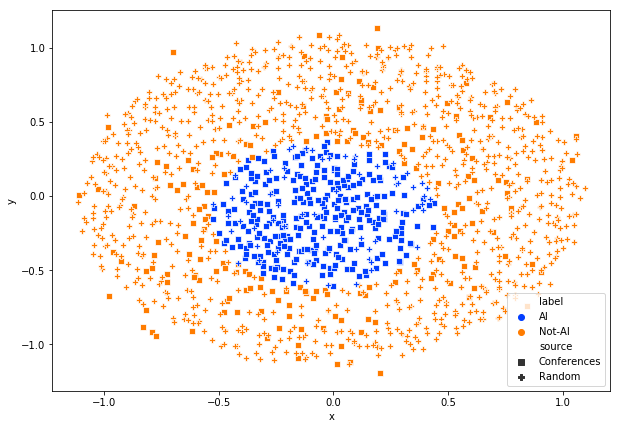

In [76]:
plot_predictions(svm, df)

In [77]:
pos,_ = predict_ai(svm, vecs, embeddings)
len(vecs), len(pos)

(2610, 10485)

In [78]:
len(pos)/len(embeddings)

0.003832166809817072

In [ ]:
print_random(pos)

In [89]:
bigquery_ids = get_ids(pos)

In [93]:
with open('ai_repo_ids.txt', 'w') as f:
    for i in bigquery_ids:
        f.write(i+'\n')

## Results

* 1787/13000 titles of papers (~13.7%) from top AI conferences were identified as "referenced in software repositories"
* Trained classifier on 2955 repositories identified from those papers
* Classified ~10500 / 2.7 million repositories as **Core AI** (0.004%)

## Evaluation

The classification model can be tuned to be more conservative or less conservative. This tuning must be decided. To decide how to tune is, the best solution is to look along the decision boundary, on both sides, and get an expert opinion on the points around this boundary. Collecting these points and getting feedback on them is a logical next step. 

Given feedback, and hand labelling, by experts we can incorporate the information new information into the tuning of this model, but could also modify our classification method as well, using the hand-labelled examples directly to learn the boundary between what is AI and what is not AI. 

Additionally, it is clearly worth seeing the overlap of our method with that of the others on the team. For example, looking at how many of the repos we identify as AI contain the list of AI keywords already used on Scopus/PatStat (and the opposite). 

We should definitely run sensitivity tests on the choices of papers and conferences. That choice is clearly important, as we are considering these things to be "accurately labelled as AI."

Interestingly, in early tests we only used a relatively small sample papers (72) from NIPS (Advances in Neural Information Processing Systems), one of the most well-known AI conferences that is most famous for neural network research. With our increased sample (2905), we seem to be picking up more software that, in many ways, seems to not be as "core" AI as what we saw before. Particularly we are seeing more: 

1. Statistical estimation software related to astronomy. 
2. Statistical estimation software related to microscopy. 
3. Math/optimization/linear-algebra software. 

Clearly, the question of whether or not these things should be considered AI is core to what we are trying to do. They all involve sophisticated statistical decompositions and heavy processing of high-dimensional data. They do not directly use general-purpose learning algorithms. Should we consider them AI? 

An example of the astronomy software:

In [103]:
print("Introduction kcarta matlab is Matlab based version of kCARTA also available under github which was designed to be the Reference Clear Sky Forward Model for NASA AIRS satellite sounder hyperspectral infrared nadir grating spectrometer	Mixed absorptions and radiances are computed using compressed tabulated absorptions	kcarta matlab is designed to be fast accurate and easy to use compressed optical depths come from Matlab based line by line code which currently uses the HITRAN 2012 lineshape parameters with CO2 linemixing and MT CKDv2 water continuum	key idea is that the profile should define the set of mixed paths	kcmix does interpolation in pressure temperature and partial pressure to the user supplied layer set and radiance calculations are done on user supplied layers")

Introduction kcarta matlab is Matlab based version of kCARTA also available under github which was designed to be the Reference Clear Sky Forward Model for NASA AIRS satellite sounder hyperspectral infrared nadir grating spectrometer	Mixed absorptions and radiances are computed using compressed tabulated absorptions	kcarta matlab is designed to be fast accurate and easy to use compressed optical depths come from Matlab based line by line code which currently uses the HITRAN 2012 lineshape parameters with CO2 linemixing and MT CKDv2 water continuum	key idea is that the profile should define the set of mixed paths	kcmix does interpolation in pressure temperature and partial pressure to the user supplied layer set and radiance calculations are done on user supplied layers


An example of "optimization" software. Automatic Differentiation is a concept used _very heavily_ in modern machine learning and neural networks. But, in and of itself, it is purely a piece of software that performs differentation on functions:

In [104]:
print("This is some basic Julia code for AutoDiff	This code was developed for Julia version If you want to use NVIDIA GPU functionality you ll need to first compile the kernels using julia cd cuda_kernels directory it is subsubdir of this README file julia include compile_kernels jl This only needs to be done once	ve only tested this on Jetson TK1 and Titan GTX under ubuntu 14 04	You may need to modify the nvcc options in the file compile_kernels jl for your architecture	To run the demos see the Demos folder start julia and then from within julia type julia include CPUstart jl or if you have an NVIDIA GPU julia include GPUstart jl then julia cd Demos julia include DemoMNIST jl Note that include GPUstart does not mean that all subsequent computations will be performed on the GPU")

This is some basic Julia code for AutoDiff	This code was developed for Julia version If you want to use NVIDIA GPU functionality you ll need to first compile the kernels using julia cd cuda_kernels directory it is subsubdir of this README file julia include compile_kernels jl This only needs to be done once	ve only tested this on Jetson TK1 and Titan GTX under ubuntu 14 04	You may need to modify the nvcc options in the file compile_kernels jl for your architecture	To run the demos see the Demos folder start julia and then from within julia type julia include CPUstart jl or if you have an NVIDIA GPU julia include GPUstart jl then julia cd Demos julia include DemoMNIST jl Note that include GPUstart does not mean that all subsequent computations will be performed on the GPU


An example of a random repository that is more "core" to what we saw before: image classification!

In [105]:
print("simple convolutional network library for image classification	Following layers are made available net layers Input net layers Convolution2D net layers Flatten net layers Softmax Simple example more comprehensive example can be found in	Only 2D convolutions are available and each convolution applies ReLU activation to its output")

simple convolutional network library for image classification	Following layers are made available net layers Input net layers Convolution2D net layers Flatten net layers Softmax Simple example more comprehensive example can be found in	Only 2D convolutions are available and each convolution applies ReLU activation to its output


In [ ]:
svm.decision_function(sample)

In [82]:
from gensim.corpora import Dictionary
from gensim.corpora.textcorpus import TextCorpus

class ReadmeCorpus(TextCorpus):
    def getstream(self):
        self.length = len(self.input)
        for line in self.input:
            yield line
        
corpus = ReadmeCorpus(readmes)
d = Dictionary((c for c in corpus.get_texts()))

In [115]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS



In [127]:
from wordcloud import WordCloud

# TODO: remove numbers in preprocessing!

stop_words = ENGLISH_STOP_WORDS | frozenset(['et', 'al', 'pdf', 'star'])

vectorizer = CountVectorizer(stop_words = stop_words, max_df = .75, ngram_range=(1,3))
vecs = vectorizer.fit_transform(readmes)
counts = np.asarray(vecs.sum(0)).reshape(-1)
di = np.array(vectorizer.get_feature_names())

idx = (counts > 100)
freqs = zip(di[idx], counts[idx])
frequencies = dict(freqs)

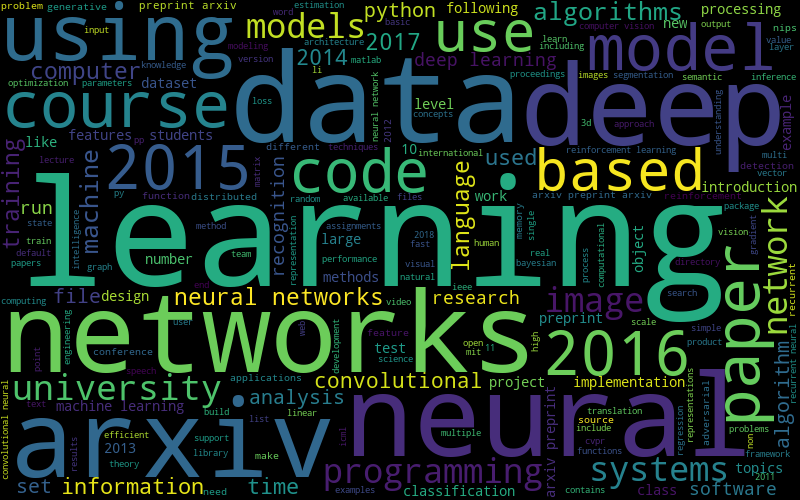

In [128]:
WordCloud(width=800, height=500).fit_words(frequencies).to_image()